In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FPT Historical Data 10 years.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']
df.size

11368

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
len(val_data)

163

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 5s 97ms/step - loss: 0.1878 - val_loss: 0.1324
Epoch 2/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0248 - val_loss: 0.0158
Epoch 3/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0115 - val_loss: 0.0166
Epoch 4/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0098 - val_loss: 0.0203
Epoch 5/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0087 - val_loss: 0.0174
Epoch 6/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0082 - val_loss: 0.0137
Epoch 7/100
14/14 [==============================] - 1s 76ms/step - loss: 0.0079 - val_loss: 0.0111
Epoch 8/100
14/14 [==============================] - 1s 78ms/step - loss: 0.0074 - val_loss: 0.0109
Epoch 9/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 10/100
14/14 [==============================] - 1s 77ms/step - loss: 0.0064 - val_loss: 0.0087

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 8ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [14]:
# 13. Dự báo 30 ngày tiếp theo

# n_steps=100
# x_input=val_data[60:].reshape(1,-1)

n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.20654164]
101
1 day input [0.11016755 0.11911866 0.07482213 0.0700023  0.07711728 0.09570806
 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825 0.06495295
 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019 0.06219876
 0.02662382 0.0130824  0.01629562 0.00550838 0.         0.00068855
 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949 0.0247877
 0.03534542 0.05324765 0.04705072 0.07137939 0.08056002 0.1211843
 0.11269222 0.0977737  0.0817076  0.07413358 0.09478999 0.10236401
 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372 0.18338306
 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921 0.16341519
 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733 0.13679137
 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398  0.14138168
 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507 0.13472573
 0.11934818 0.11636447 0.09088823 0.09295387 0.1124627  0.09915079
 0.09111774 0.10970852 0.11544641 0.12347946 0.10580675 0.09410145
 0.05737893 0.09410145 0.1168235  0

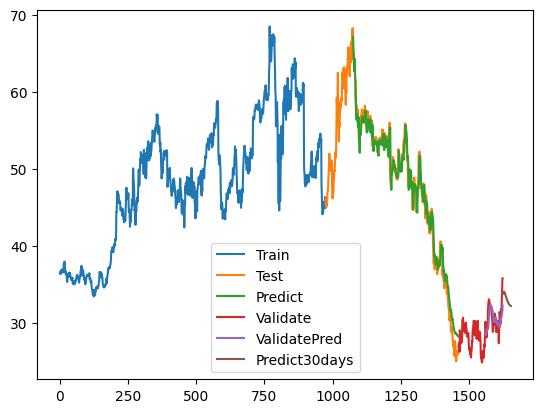

In [15]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_pre_data_index = pd.RangeIndex(start=train_size+n_steps+1, stop=train_size+test_size, step=1)
plt.plot(test_pre_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_pre_data_index = pd.RangeIndex(start=train_size+test_size+n_steps+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_pre_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
def mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)
test_mape = mape(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)
valid_mape = mape(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)

Testing RMSE: 47.79222776165416
Testing MAE: 47.04528102705252
Testing MAPE: 22972.284424797104
Validation RMSE: 30.42234245660719
Validation MAE: 30.405822578340704
Validation MAPE: 24734.097780015207


In [17]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[33.89901937 33.99202416 33.88203385 34.04354943 33.84833487 34.08313901
 33.93294689 33.88947094 33.75181182 33.69417912]


In [18]:
print(df['Price'].tail(10))

1614    31.31
1615    29.86
1616    30.96
1617    31.28
1618    31.82
1619    31.34
1620    33.07
1621    33.91
1622    35.58
1623    35.82
Name: Price, dtype: float64


In [19]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_pre_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_pre_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'NVDA CNN_Bi_LSTM data (6:3:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [20]:
len(df1)

1624

In [21]:
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)

In [22]:
prediect_data_index

RangeIndex(start=1623, stop=1653, step=1)

In [23]:
prediect_data_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)

In [24]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)

In [25]:
len(val_data)

163

In [26]:
len(df1) - len(train_data) - len(test_data)

163

In [27]:
len(train_data) 

974

In [28]:
test_data_index

RangeIndex(start=974, stop=1461, step=1)

In [29]:
len(train_data) + len(test_data)

1461

In [30]:
val_data_index

RangeIndex(start=1461, stop=1624, step=1)

In [31]:
prediect_data_index

RangeIndex(start=1624, stop=1654, step=1)